### Import libraries

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline

### Load data
#### The dataset was downloaded from [insideairbnb](http://insideairbnb.com/get-the-data.html) for the city of Austin, Date Compiled on March 17th, 2020. 
#### Let's import the dataset and take a look at the first few observations.

In [2]:
# import dataset
df = pd.read_csv('data/listings.csv', low_memory=False, index_col='id')
df.head()

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2265,https://www.airbnb.com/rooms/2265,20200317143754,2020-03-17,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,A 2013 Genuine Buddy Scooter 125 may be availa...,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18
5245,https://www.airbnb.com/rooms/5245,20200317143754,2020-03-17,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,Please note: A two story studio was built in t...,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07
5456,https://www.airbnb.com/rooms/5456,20200317143754,2020-03-17,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...,none,My neighborhood is ideally located if you want...,Parking on street requires a permit. Permits ...,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,3.94
5769,https://www.airbnb.com/rooms/5769,20200317143754,2020-03-17,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...,NaN,...,f,f,moderate,t,t,1,0,1,0,2.12
6413,https://www.airbnb.com/rooms/6413,20200317143754,2020-03-17,Gem of a Studio near Downtown,"Great studio apartment, perfect for couples or...",!!!!! SXSW info !!!!! Presently open (again!) ...,"Great studio apartment, perfect for couples or...",none,Travis Heights is one of the oldest neighborho...,Our calendar only extends a few months. If you...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.90


In [3]:
# shape
df.shape

(11668, 105)

The Airbnb dataset for Austin, TX consists of 106 features and 11668 observations. We need to look at these features closely and drop the ones that do not help our model to predict the rental prices. 

In [4]:
# specifying max_cols=df.shape[1] so we can look at the columns in df.info()
df.info(max_cols=df.shape[1])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11668 entries, 2265 to 42931550
Data columns (total 105 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   11668 non-null  object 
 1   scrape_id                                     11668 non-null  int64  
 2   last_scraped                                  11668 non-null  object 
 3   name                                          11668 non-null  object 
 4   summary                                       11244 non-null  object 
 5   space                                         9083 non-null   object 
 6   description                                   11461 non-null  object 
 7   experiences_offered                           11668 non-null  object 
 8   neighborhood_overview                         7937 non-null   object 
 9   notes                                         5553 non

In [5]:
# ordering null columns based on the number of null values in each column
print('Columns with Null values by their count:')
df.isnull().sum().sort_values(ascending=False)[:25]

Columns with Null values by their count:


neighbourhood_group_cleansed    11668
medium_url                      11668
xl_picture_url                  11668
thumbnail_url                   11668
license                         11621
square_feet                     11476
monthly_price                   10931
weekly_price                    10793
notes                            6115
access                           4917
transit                          4370
host_about                       4099
interaction                      3862
house_rules                      3759
neighborhood_overview            3731
host_response_time               3462
host_response_rate               3462
security_deposit                 3100
host_acceptance_rate             2765
review_scores_location           2675
review_scores_value              2674
review_scores_checkin            2670
review_scores_communication      2670
review_scores_accuracy           2669
review_scores_cleanliness        2669
dtype: int64

Using MSNO to look at Misisng Values in 25 columns visually.

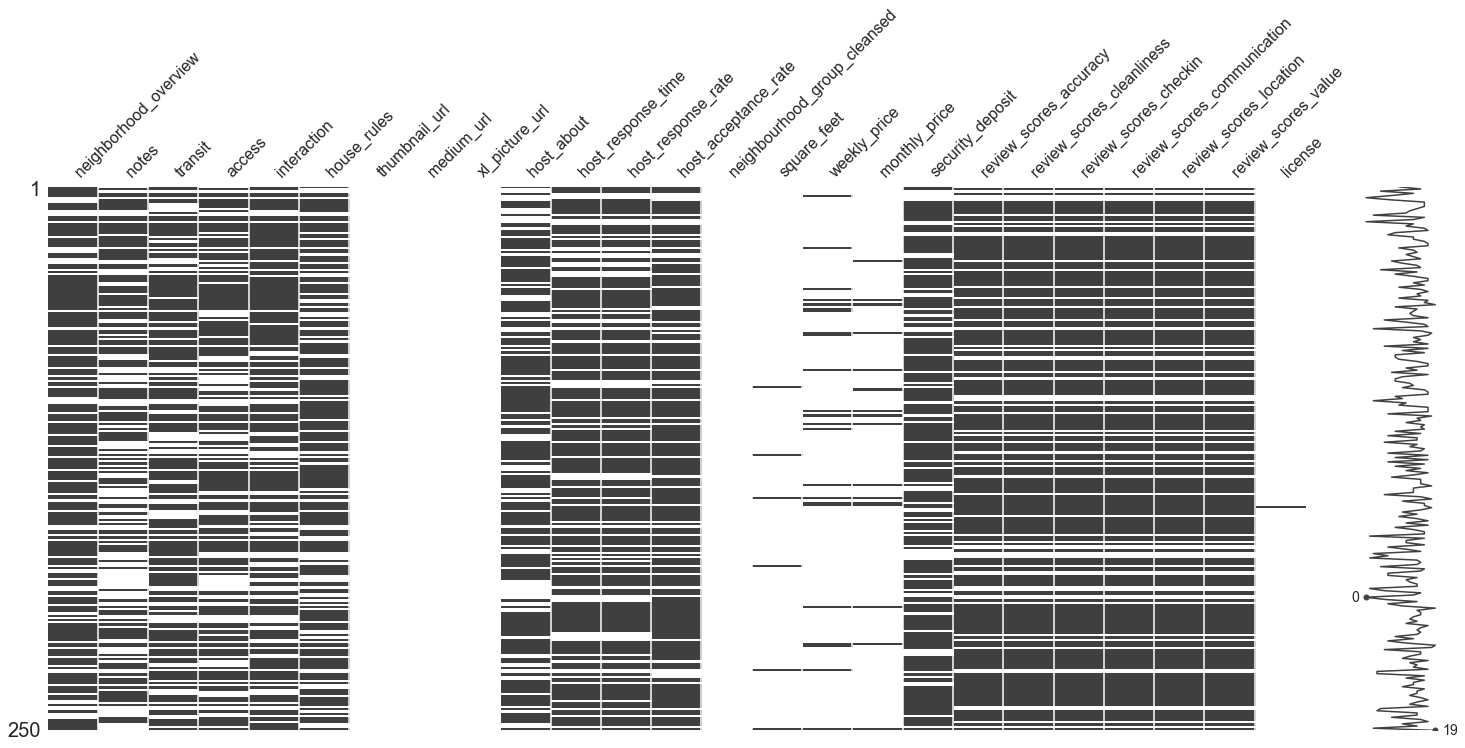

In [6]:
filtered_data = msno.nullity_filter(df, filter='bottom', n=25, p=0.999) # or filter='top'
msno.matrix(filtered_data.sample(250))

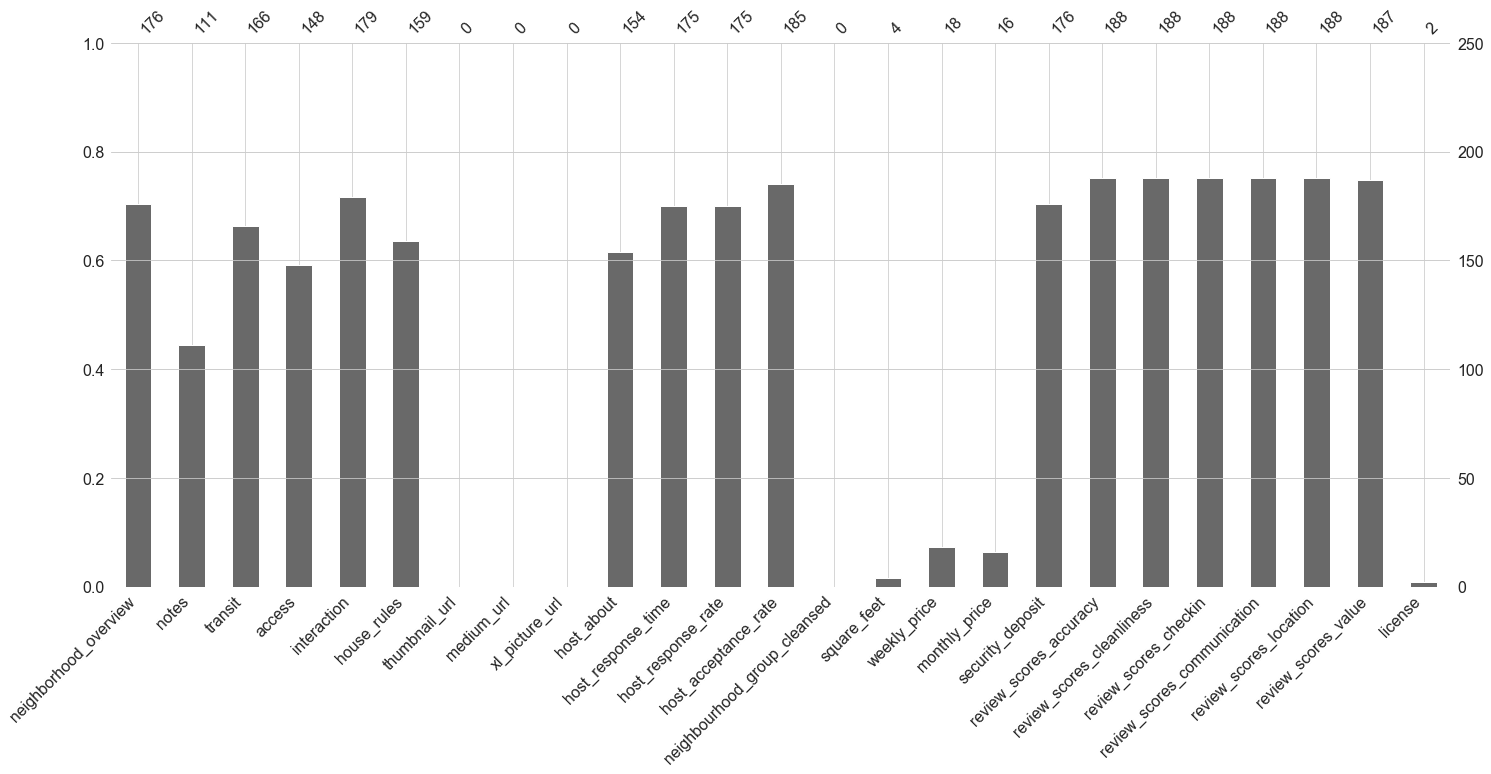

In [7]:
msno.bar(filtered_data.sample(250))

Features like 'square_feet', 'monthly_price' or 'weekly_price' have a lot of NULL values but we can use bedroom, bathroom, and accommodates data as a replacement for space size and also use 'price' for our prediction instead of 'monthly_price' or 'weekly_price'. 

In [8]:
df[['price','monthly_price', 'weekly_price']]

,price,monthly_price,weekly_price
id,,,
2265,$225.00,NaN,NaN
5245,$100.00,NaN,NaN
5456,$95.00,NaN,NaN
5769,$40.00,NaN,$160.00
6413,$99.00,"$1,900.00",$700.00
...,...,...,...
42929742,$60.00,NaN,NaN
42930229,$40.00,NaN,NaN
42930678,$40.00,NaN,NaN


In [9]:
# Looking at describe() to get some insights on price and other numerical values
df.describe()

,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_listings_count,host_total_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.166800e+04,0.0,0.0,0.0,1.166800e+04,11666.000000,11666.000000,11668.000000,0.0,11580.000000,...,8999.000000,8998.000000,8998.000000,8993.000000,8994.000000,11668.000000,11668.000000,11668.000000,11668.000000,9146.000000
mean,2.020032e+13,NaN,NaN,NaN,7.673078e+07,66.963398,66.963398,78722.143469,NaN,78721.910535,...,9.607512,9.838964,9.848188,9.779162,9.587725,13.572506,12.477288,0.715975,0.350531,1.721717
std,2.511826e+00,NaN,NaN,NaN,8.628560e+07,281.215856,281.215856,20.689544,NaN,20.859859,...,0.838195,0.611808,0.600158,0.615760,0.794404,41.256138,41.041238,2.807207,3.948567,2.122986
min,2.020032e+13,NaN,NaN,NaN,2.300000e+01,0.000000,0.000000,78701.000000,NaN,78617.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.020032e+13,NaN,NaN,NaN,8.761906e+06,1.000000,1.000000,78704.000000,NaN,78703.000000,...,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.260000
50%,2.020032e+13,NaN,NaN,NaN,3.939813e+07,1.000000,1.000000,78717.000000,NaN,78705.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,2.020032e+13,NaN,NaN,NaN,1.185659e+08,4.000000,4.000000,78744.000000,NaN,78744.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000,3.000000,1.000000,0.000000,2.510000
max,2.020032e+13,NaN,NaN,NaN,3.416244e+08,2016.000000,2016.000000,78759.000000,NaN,78767.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,248.000000,248.000000,31.000000,48.000000,41.270000


Notice that 'price' is not included on the describe() above! Let's investigate why 'price' did not show up!

In [10]:
# describe for price
df['price'].head()

id
2265    $225.00
5245    $100.00
5456     $95.00
5769     $40.00
6413     $99.00
Name: price, dtype: object

'price' is type object and needs to be transformed to the correct data type.

In [11]:
# Convert price to from currency to float
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float, 2)

In [12]:
# Verify price type is float
df['price'].head()

id
2265    225.0
5245    100.0
5456     95.0
5769     40.0
6413     99.0
Name: price, dtype: float64

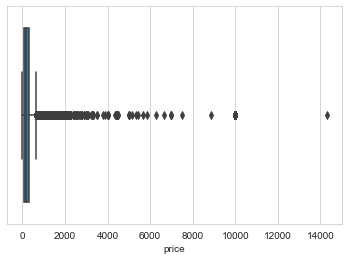

In [13]:
sns.boxplot(df['price'])

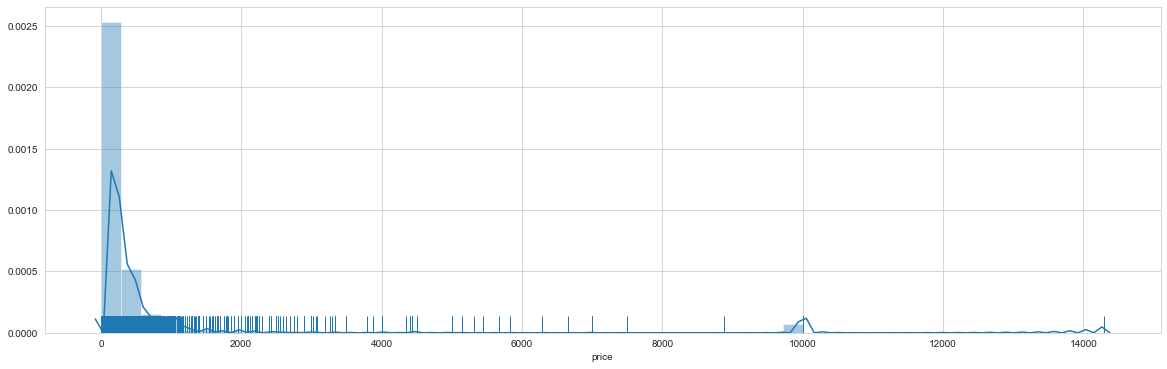

In [14]:
plt.figure(figsize=(20,6))
sns.distplot(df['price'], rug=True)

In [15]:
df[df['price']==0]

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
20269052,https://www.airbnb.com/rooms/20269052,20200317143754,2020-03-17,20 ft from Restaurants/Bars. Beautifully furni...,It's completely furnished. King size tempur-pe...,NaN,It's completely furnished. King size tempur-pe...,none,Super quiet complex right in the middle of dow...,NaN,...,f,f,flexible,f,f,1,0,1,0,NaN
20541331,https://www.airbnb.com/rooms/20541331,20200317143754,2020-03-17,"Bouldin huge private suite and bath, 600 sq ft b",This is your private living room and bedroom a...,"The house is about 5000 sq ft, 2 adults live h...",This is your private living room and bedroom a...,none,Bouldin is an established neighborhood with a ...,We don't cook breakfast - 7th Flag coffee is a...,...,f,f,moderate,f,t,5,0,5,0,0.07
21378172,https://www.airbnb.com/rooms/21378172,20200317143754,2020-03-17,Zilker Park - Private Yard w/ separate quarters,Incredible location in Central Austin just ste...,Fantastic location nestled in the heart of 787...,Incredible location in Central Austin just ste...,none,We are in the middle of the Zilker neighborhoo...,NOTE on TAXES: ALL bookings will be assessed t...,...,f,f,strict_14_with_grace_period,f,f,6,6,0,0,0.54


In [16]:
df.at[21378172, 'price'] = 435
df.at[20541331, 'price'] = 130
df.at[20269052, 'price'] = 104

In [17]:
df[df['price'] < 10]['property_type'].value_counts()

House          3
Guest suite    1
Cabin          1
Name: property_type, dtype: int64

In [18]:
df.price.describe()

count    11668.000000
mean       484.295166
std       1480.340150
min          1.000000
25%         80.000000
50%        149.000000
75%        300.000000
max      14298.000000
Name: price, dtype: float64

Defined a mask for price based on below 25% quartile as 'low', below 50% as 'med' and the rest was set as 'high'

In [19]:
'''
price_bins=[]
for price in df.price:
    if price < 81:
        price_bins.append('low')
    if price < 150:
        price_bins.append('med')
    else:
        price_bins.append('high')
'''

"\nprice_bins=[]\nfor price in df.price:\n    if price < 81:\n        price_bins.append('low')\n    if price < 150:\n        price_bins.append('med')\n    else:\n        price_bins.append('high')\n"

In [20]:
#[[x,price_bins.count(x)] for x in set(price_bins)]

In [21]:
#df['price_bins'] = pd.Series(price_bins)

In [22]:
#df[['price', 'price_bins']]

In [23]:
#print(df['price_bins'].value_counts())
#df['price_bins'].value_counts().plot(kind='bar');

In [24]:
'''
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='price_bins', palette='Dark2', ax=ax);
'''

"\nsns.set_style('ticks')\nfig, ax = plt.subplots()\nfig.set_size_inches(11, 8)\nsns.scatterplot(data=df, x='longitude', y='latitude', hue='price_bins', palette='Dark2', ax=ax);\n"

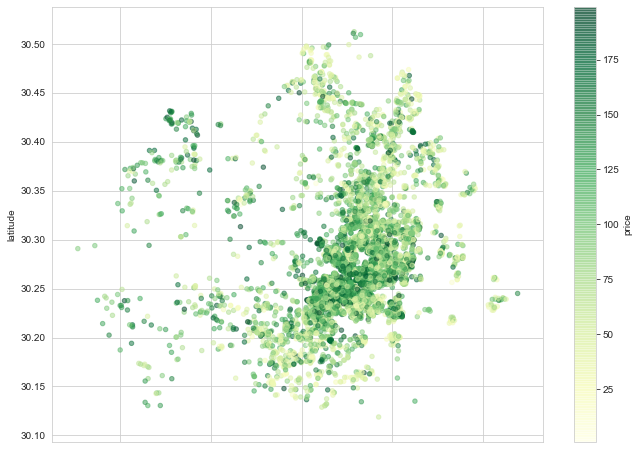

In [25]:
df[df['price']<200].plot.scatter(x='longitude', y='latitude', c='price', figsize=(11,8), cmap='YlGn', alpha=0.5);

House                 5105
Apartment             3109
Condominium           1066
Guesthouse             539
Townhouse              417
Bungalow               298
Guest suite            271
Serviced apartment     166
Loft                   138
Camper/RV               91
Cottage                 68
Tiny house              64
Resort                  48
Villa                   44
Other                   39
Boutique hotel          39
Bed and breakfast       31
Hostel                  25
Aparthotel              24
Cabin                   18
Tent                    12
Campsite                 9
Farm stay                9
Boat                     6
Treehouse                5
Yurt                     4
Hotel                    4
Barn                     4
Houseboat                3
Dome house               3
Tipi                     3
Chalet                   2
Bus                      2
Earth house              1
Nature lodge             1
Name: property_type, dtype: int64


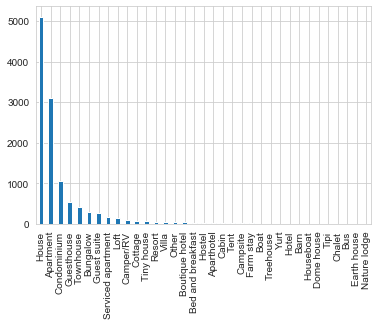

In [26]:
# Let's look at the property_type distribution
print(df['property_type'].value_counts())
df['property_type'].value_counts().plot(kind='bar');

Entire home/apt    8848
Private room       2610
Shared room         159
Hotel room           51
Name: room_type, dtype: int64


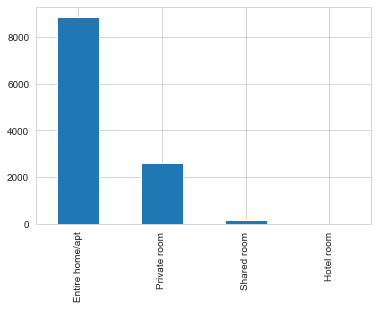

In [27]:
# Let's look at the room_type distribution
print(df['room_type'].value_counts())
df['room_type'].value_counts().plot(kind='bar');

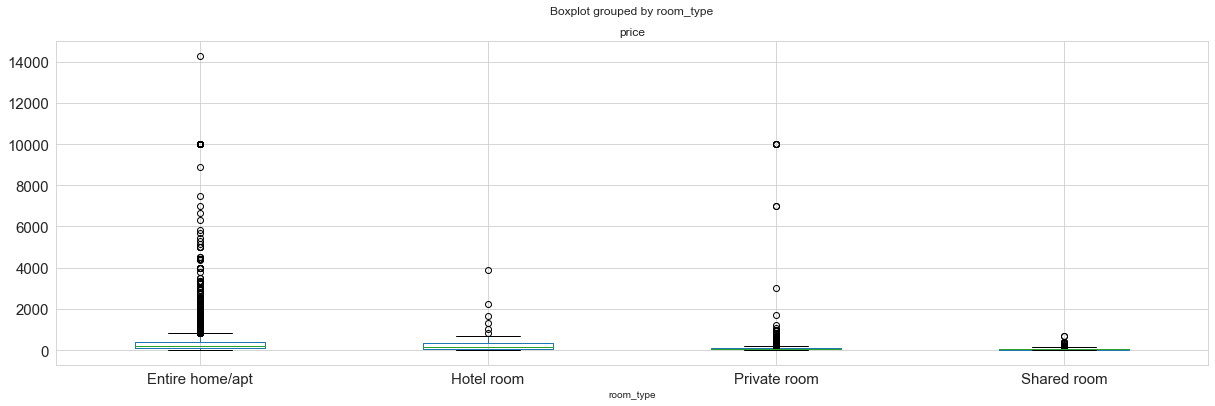

In [28]:
df.boxplot(column='price', by='room_type', figsize=(20,6), fontsize=15)

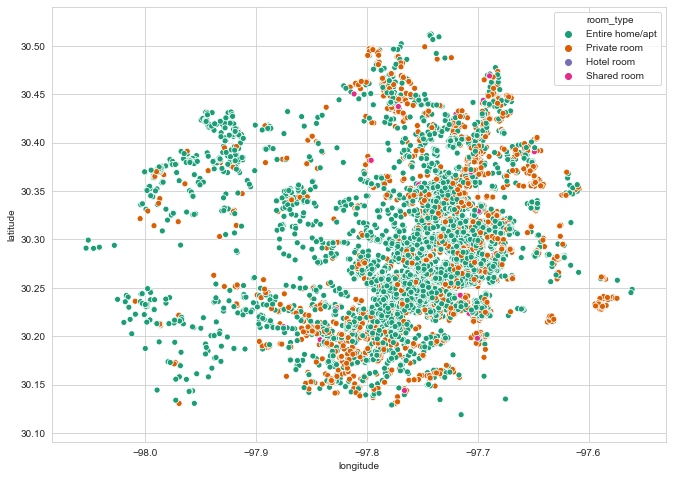

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='room_type', palette='Dark2', ax=ax);

In [30]:
#df['lat_long']= list(zip(df['latitude'], df['longitude']))

In [31]:
#df[['lat_long', 'latitude', 'longitude']]

East Downtown          1087
Downtown                742
Travis Heights          462
University of Texas     434
East Riverside          374
                       ... 
Gateway                  22
Mesa Park                12
Cat Mountian             11
Walnut Creek              7
Canyon Mesa               6
Name: neighbourhood, Length: 78, dtype: int64


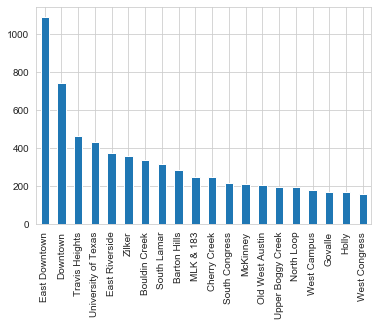

In [32]:
# Let's look at the neighbourhood distribution 
print(df['neighbourhood'].value_counts())
df['neighbourhood'].value_counts()[:20].plot(kind='bar');

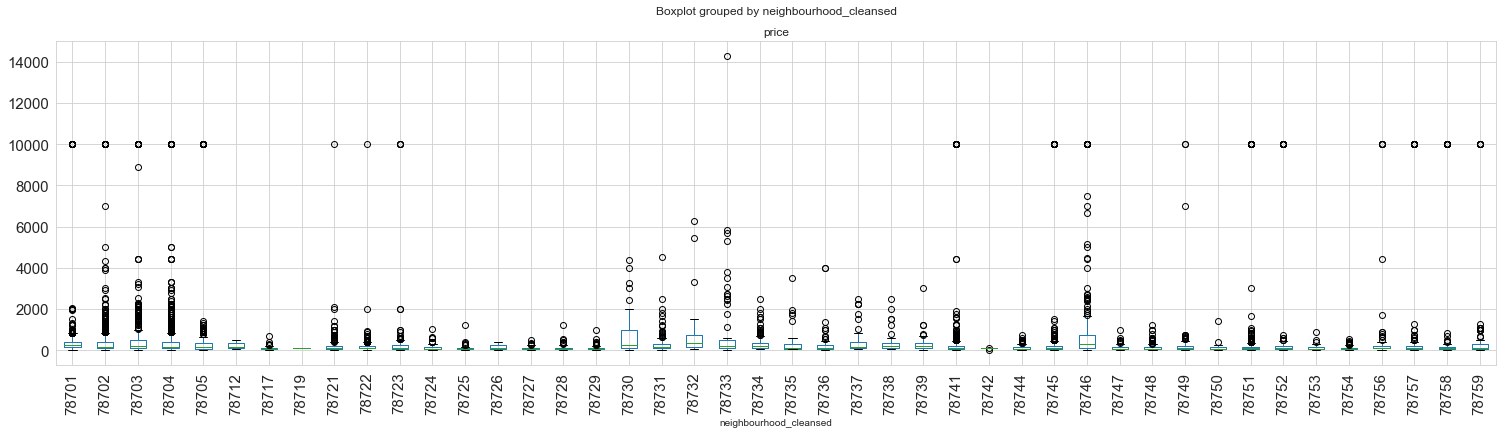

In [33]:
df.boxplot(column='price', by='neighbourhood_cleansed', figsize=(25,6), fontsize=15, rot=90)

In [34]:
df[['neighbourhood_cleansed', 'neighbourhood', 'neighbourhood_group_cleansed']]

,neighbourhood_cleansed,neighbourhood,neighbourhood_group_cleansed
id,,,
2265,78702,East Downtown,NaN
5245,78702,East Downtown,NaN
5456,78702,East Downtown,NaN
5769,78729,SW Williamson Co.,NaN
6413,78704,Travis Heights,NaN
...,...,...,...
42929742,78704,South Congress,NaN
42930229,78741,Parker Lane,NaN
42930678,78741,East Riverside,NaN


In [35]:
columns_list = ['room_type', 'price', 'accommodates', 'bathrooms', 'bedrooms',  
                'host_is_superhost', 'neighbourhood_cleansed', 'longitude', 'latitude', 
                'number_of_reviews', 'availability_365', 'review_scores_rating', 
                'minimum_nights', 'listing_url']

df = df[columns_list]

In [36]:
df.head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,review_scores_rating,minimum_nights,listing_url
id,,,,,,,,,,,,,,
2265,Entire home/apt,225.0,4,2.0,2.0,t,78702,-97.71398,30.27750,24,0,93.0,30,https://www.airbnb.com/rooms/2265
5245,Private room,100.0,2,1.0,1.0,t,78702,-97.71379,30.27577,9,0,91.0,30,https://www.airbnb.com/rooms/5245
5456,Entire home/apt,95.0,3,1.0,1.0,t,78702,-97.73448,30.26112,529,334,97.0,2,https://www.airbnb.com/rooms/5456
5769,Private room,40.0,2,1.0,1.0,t,78729,-97.78422,30.45697,257,14,98.0,1,https://www.airbnb.com/rooms/5769
6413,Entire home/apt,99.0,2,1.0,0.0,t,78704,-97.73726,30.24829,112,0,99.0,3,https://www.airbnb.com/rooms/6413


C:\Users\rtalebiz\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


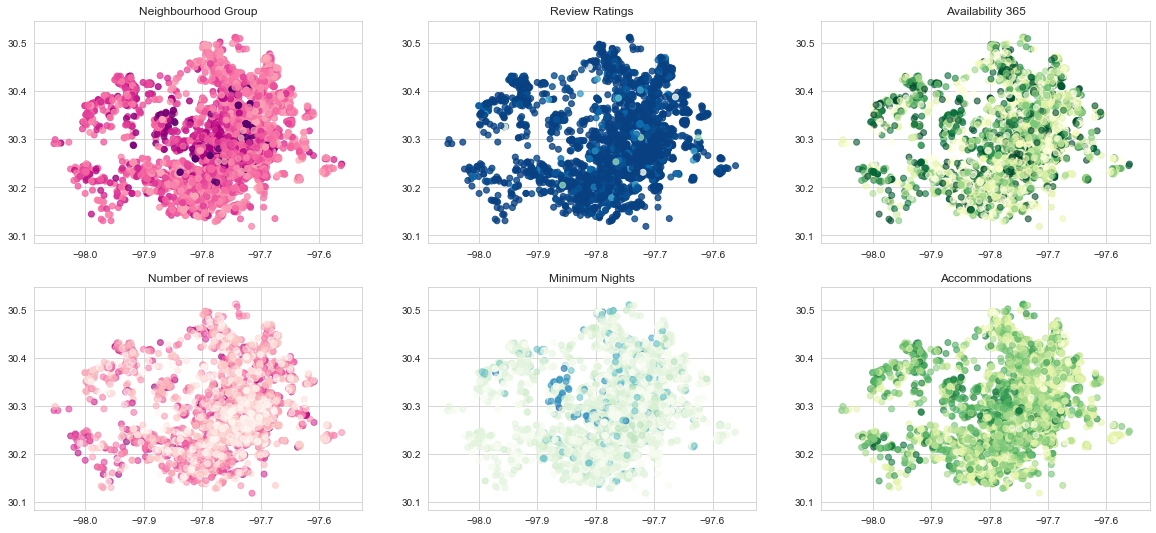

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

axes[0,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['price']), cmap='RdPu', alpha=0.8)
axes[0,0].set_title('Neighbourhood Group')

axes[0,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['review_scores_rating']), cmap='GnBu', alpha=0.8)
axes[0,1].set_title('Review Ratings')

axes[0,2].scatter(x=df['longitude'], y=df['latitude'], c=df['availability_365'], cmap='YlGn', alpha=0.6)
axes[0,2].set_title('Availability 365')

axes[1,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['number_of_reviews']), cmap='RdPu', alpha=0.6)
axes[1,0].set_title('Number of reviews')

axes[1,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['minimum_nights']), cmap='GnBu', alpha=0.6)
axes[1,1].set_title('Minimum Nights')

axes[1,2].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['accommodates']), cmap='YlGn', alpha=0.6)
axes[1,2].set_title('Accommodations')

plt.show()

Noting for cleanup:

* Price needs to be converted to float (This has been done already)
* Missing NaN values need data imputed or rows removed
* Categorical columns need to be converted to dummy variables (get_dummies)
* To continue the data exploration, I need to perform some cleanup procedures. I'll create a cleanup function to put these cleaning steps together.

In [38]:
print("Dataset has {} row entries.".format(df.shape[0]))

Dataset has 11668 row entries.


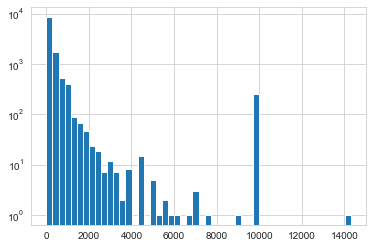

In [39]:
# Let's look at the rental price distribution
fig, ax = plt.subplots()
ax.hist(df['price'], bins=50)
ax.set_yscale("log", nonposy='clip')
plt.show();

There are some oddly high prices (> $2000) that we need to examine to find out if the rental is a large proporty. We'll look at price per person (price / accommodates) to check for outliers.

In [40]:
# Create 'price_per_person' feature
df['price_per_person'] = df['price']/df['accommodates']

df['price_per_person'].value_counts().sort_index(ascending=False).head(15)

5000.000000     13
3500.000000      1
3333.333333      3
2500.000000    161
2000.000000      4
1750.000000      1
1666.666667     65
1500.000000      1
1200.000000      1
1191.500000      1
1081.000000      1
1000.000000      4
980.000000       1
937.500000       1
875.000000       1
Name: price_per_person, dtype: int64

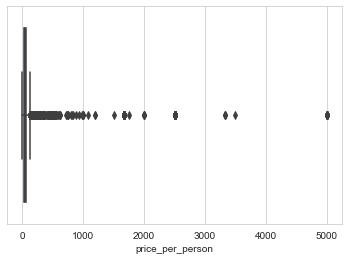

In [41]:
sns.boxplot(df['price_per_person'])

In [42]:
df[df['price_per_person'] > 1500.00][['price', 'number_of_reviews', 'accommodates']].sort_values('price', ascending=False)

,price,number_of_reviews,accommodates
id,,,
39558664,10000.0,15,6
40470110,10000.0,4,4
40529835,10000.0,6,4
40531839,10000.0,7,4
40635481,10000.0,19,4
...,...,...,...
37290749,10000.0,14,4
37293318,10000.0,20,4
37326233,10000.0,23,6


In [43]:
df[df['price_per_person'] <= 1500].price.value_counts().sort_index()

1.0         4
5.0         1
10.0        9
14.0       10
15.0        3
           ..
7000.0      1
7500.0      1
8880.0      1
10000.0     4
14298.0     1
Name: price, Length: 705, dtype: int64

In [44]:
df.loc[df['price'] == 10000.0]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,review_scores_rating,minimum_nights,listing_url,price_per_person
id,,,,,,,,,,,,,,,
4538217,Entire home/apt,10000.0,10,3.0,4.0,f,78723,-97.68111,30.31850,3,0,100.0,30,https://www.airbnb.com/rooms/4538217,1000.000000
16268096,Entire home/apt,10000.0,4,1.0,2.0,f,78703,-97.77171,30.30439,0,365,NaN,30,https://www.airbnb.com/rooms/16268096,2500.000000
17607193,Private room,10000.0,2,1.0,1.0,f,78723,-97.69715,30.29481,0,364,NaN,1,https://www.airbnb.com/rooms/17607193,5000.000000
23003072,Entire home/apt,10000.0,5,1.0,1.0,f,78701,-97.75059,30.26969,1,180,100.0,500,https://www.airbnb.com/rooms/23003072,2000.000000
31740528,Entire home/apt,10000.0,6,2.0,2.0,f,78741,-97.72438,30.24056,60,6,97.0,1,https://www.airbnb.com/rooms/31740528,1666.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42858851,Entire home/apt,10000.0,5,1.0,2.0,f,78704,-97.76041,30.25576,0,126,NaN,1,https://www.airbnb.com/rooms/42858851,2000.000000
42860293,Entire home/apt,10000.0,6,2.0,2.0,f,78746,-97.78618,30.26654,0,180,NaN,1,https://www.airbnb.com/rooms/42860293,1666.666667
42861546,Entire home/apt,10000.0,4,1.0,1.0,f,78752,-97.72279,30.33052,0,177,NaN,1,https://www.airbnb.com/rooms/42861546,2500.000000


Upon reviewing the url listings, the houses listed as with extreme prices looked like automated (or unmaintained) listings with little to no reviews with some being incorrectly priced at the time of the source data scrape. I'm opting to remove them from this analysis since they don't pass my common sense as a consumer. However, it would be intersting to examine other popular cities to see if they had similar outliers.

In [45]:
# remove rows with > $1000 per person
df = df.loc[df['price_per_person'] <= 1500.00]

# verify removal
df['price_per_person'].value_counts().sort_index(ascending=False).head()

1500.0    1
1200.0    1
1191.5    1
1081.0    1
1000.0    4
Name: price_per_person, dtype: int64

In [46]:
df.describe()

,price,accommodates,bathrooms,bedrooms,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,review_scores_rating,minimum_nights,price_per_person
count,11420.000000,11420.000000,11407.000000,11405.000000,11420.000000,11420.000000,11420.000000,11420.000000,11420.000000,8796.000000,11420.000000,11420.000000
mean,278.174781,4.714711,1.552599,1.798509,78721.969615,-97.751284,30.277966,31.996410,134.221016,96.095612,5.326970,58.244281
std,488.243912,3.283394,0.879782,1.280913,20.598197,0.056844,0.057473,64.170859,135.763295,7.072182,16.136517,71.824475
min,1.000000,1.000000,0.000000,0.000000,78701.000000,-98.053550,30.118850,0.000000,0.000000,20.000000,1.000000,0.200000
25%,80.000000,2.000000,1.000000,1.000000,78703.000000,-97.767610,30.244397,1.000000,0.000000,95.000000,1.000000,25.000000
50%,143.000000,4.000000,1.000000,1.000000,78717.000000,-97.744910,30.266685,7.000000,86.000000,98.000000,2.000000,37.500000
75%,299.000000,6.000000,2.000000,2.000000,78744.000000,-97.721127,30.298212,32.000000,274.000000,100.000000,3.000000,62.500000
max,14298.000000,33.000000,17.000000,23.000000,78759.000000,-97.560620,30.512280,947.000000,365.000000,100.000000,365.000000,1500.000000


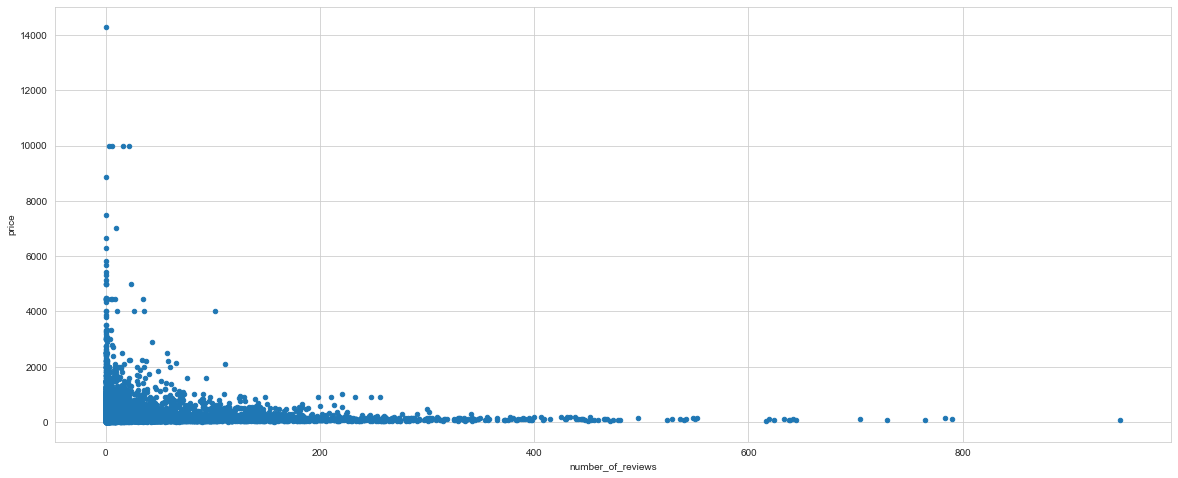

In [47]:
df.plot.scatter(x='number_of_reviews', y='price', figsize=(20,8))

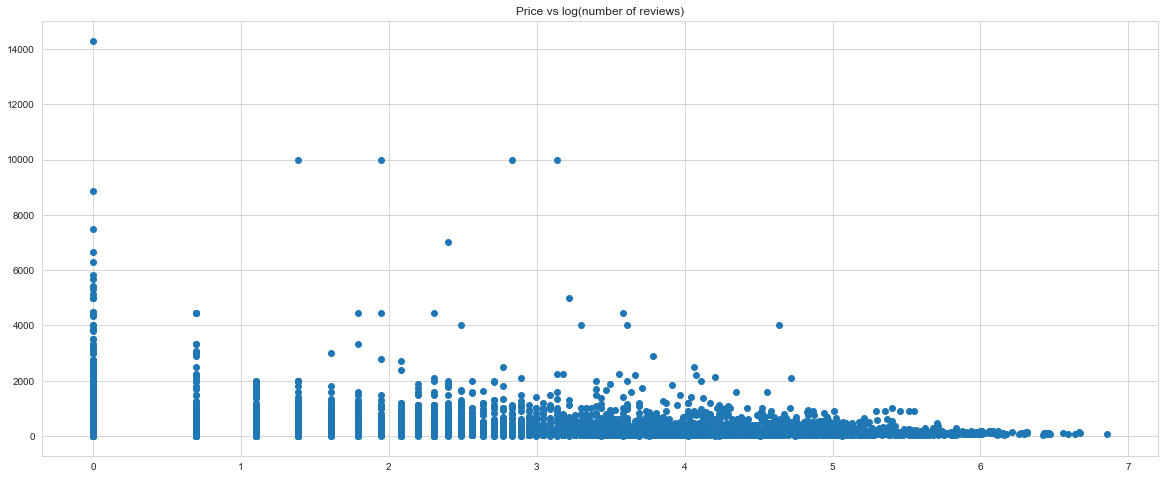

In [48]:
plt.figure(figsize=(20,8))
plt.scatter(np.log(1+df['number_of_reviews']), df['price'])
plt.title('Price vs log(number of reviews)');

The review ratings (review_scores_rating) are missing a lot of data. However, due to the small size of the data set, I'll opt to fill the missing values of the ratings scores at the cost of diluting the ratings feature importance. Before I do this, I'll save a copy of the DataFrame in it's current state since I want to look at a plot of price vs. rating later.

In [49]:
# Imputed mean value of review scores to missing data in review_scores_rating feature
print("Filling NaN 'review_scores_rating' with {:.3f}.".format(df['review_scores_rating'].mean()))
df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)

Filling NaN 'review_scores_rating' with 96.096.


The bathrooms feature is missing some data. I'll update the NaNs based on the standard ratio of the number of bathrooms needed in a home which is two for every three rooms. I'll assign a bathroom for every 2 people.

In [50]:
df[df['bathrooms'].isnull()].head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,review_scores_rating,minimum_nights,listing_url,price_per_person
id,,,,,,,,,,,,,,,
247770,Entire home/apt,175.0,5,NaN,3.0,f,78723,-97.68496,30.30340,1,0,80.000000,2,https://www.airbnb.com/rooms/247770,35.000000
314152,Entire home/apt,350.0,4,NaN,2.0,f,78730,-97.79621,30.35672,0,0,96.095612,4,https://www.airbnb.com/rooms/314152,87.500000
337125,Private room,80.0,2,NaN,1.0,f,78759,-97.76717,30.42198,33,83,96.000000,32,https://www.airbnb.com/rooms/337125,40.000000
342919,Entire home/apt,400.0,3,NaN,2.0,f,78702,-97.72019,30.25820,0,0,96.095612,3,https://www.airbnb.com/rooms/342919,133.333333
353955,Entire home/apt,225.0,2,NaN,2.0,f,78746,-97.80005,30.34442,1,0,80.000000,3,https://www.airbnb.com/rooms/353955,112.500000


In [51]:
# Replacing all 0 values in bathrooms with 'NaN'
df['bathrooms'].replace(0, np.nan, inplace=True)

In [52]:
# Bathrooms is getting scaled later, so I do not care about making it a discrete value
# Also 0.5 is commonly known as a 'half-bath'
df['bathrooms'].fillna((df['accommodates']//2), inplace=True)

In [53]:
# Check to make sure bathrooms NaN values have been filled correctly. 
df.loc[[314152]]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,review_scores_rating,minimum_nights,listing_url,price_per_person
id,,,,,,,,,,,,,,,
314152,Entire home/apt,350.0,4,2.0,2.0,f,78730,-97.79621,30.35672,0,0,96.095612,4,https://www.airbnb.com/rooms/314152,87.5


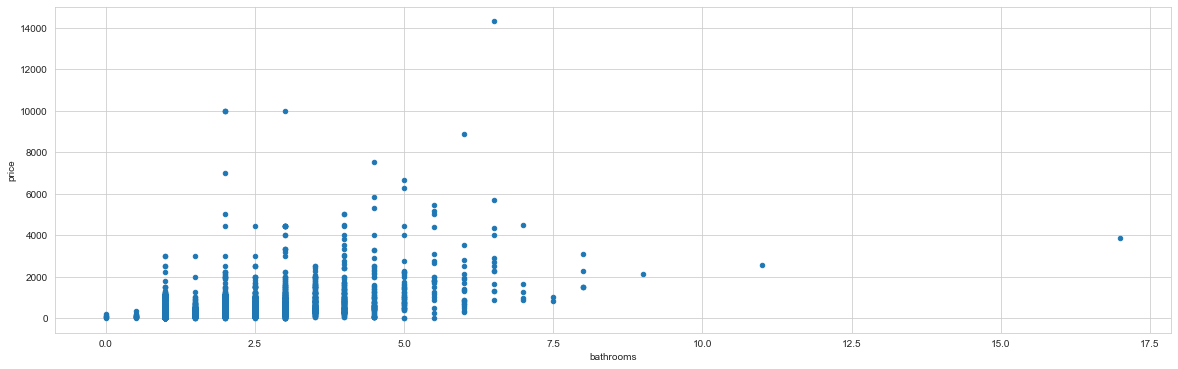

In [54]:
df.plot.scatter(x='bathrooms', y='price', figsize=(20,6))

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11420 entries, 2265 to 42931550
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   room_type               11420 non-null  object 
 1   price                   11420 non-null  float64
 2   accommodates            11420 non-null  int64  
 3   bathrooms               11420 non-null  float64
 4   bedrooms                11405 non-null  float64
 5   host_is_superhost       11418 non-null  object 
 6   neighbourhood_cleansed  11420 non-null  int64  
 7   longitude               11420 non-null  float64
 8   latitude                11420 non-null  float64
 9   number_of_reviews       11420 non-null  int64  
 10  availability_365        11420 non-null  int64  
 11  review_scores_rating    11420 non-null  float64
 12  minimum_nights          11420 non-null  int64  
 13  listing_url             11420 non-null  object 
 14  price_per_person        11420 no

In [56]:
df.isnull().sum()

room_type                  0
price                      0
accommodates               0
bathrooms                  0
bedrooms                  15
host_is_superhost          2
neighbourhood_cleansed     0
longitude                  0
latitude                   0
number_of_reviews          0
availability_365           0
review_scores_rating       0
minimum_nights             0
listing_url                0
price_per_person           0
dtype: int64

In [57]:
df[df['bedrooms'].isnull()].head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,review_scores_rating,minimum_nights,listing_url,price_per_person
id,,,,,,,,,,,,,,,
38819415,Entire home/apt,100.0,2,1.0,NaN,f,78701,-97.73815,30.27715,0,177,96.095612,5,https://www.airbnb.com/rooms/38819415,50.0
38955548,Entire home/apt,100.0,2,1.0,NaN,t,78704,-97.76369,30.25503,28,31,99.000000,2,https://www.airbnb.com/rooms/38955548,50.0
40171545,Entire home/apt,80.0,4,1.0,NaN,f,78722,-97.70992,30.28476,4,88,100.000000,1,https://www.airbnb.com/rooms/40171545,20.0
42145069,Entire home/apt,80.0,2,1.0,NaN,t,78758,-97.72143,30.39580,5,344,100.000000,1,https://www.airbnb.com/rooms/42145069,40.0
42485149,Entire home/apt,85.0,2,1.0,NaN,f,78723,-97.67123,30.31082,0,259,96.095612,1,https://www.airbnb.com/rooms/42485149,42.5


In [58]:
(df['bathrooms'] == 0).sum()

6

In [59]:
df[df['bedrooms'] == 0]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,review_scores_rating,minimum_nights,listing_url,price_per_person
id,,,,,,,,,,,,,,,
6413,Entire home/apt,99.0,2,1.0,0.0,t,78704,-97.73726,30.24829,112,0,99.000000,3,https://www.airbnb.com/rooms/6413,49.500000
56690,Entire home/apt,150.0,2,1.0,0.0,t,78704,-97.75121,30.24440,169,77,99.000000,2,https://www.airbnb.com/rooms/56690,75.000000
141550,Entire home/apt,111.0,3,1.0,0.0,t,78702,-97.72709,30.25582,439,163,97.000000,1,https://www.airbnb.com/rooms/141550,37.000000
219168,Entire home/apt,250.0,2,1.0,0.0,f,78704,-97.74531,30.24503,180,0,100.000000,2,https://www.airbnb.com/rooms/219168,125.000000
224603,Entire home/apt,105.0,2,1.0,0.0,f,78751,-97.72679,30.30788,104,102,99.000000,30,https://www.airbnb.com/rooms/224603,52.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42852666,Entire home/apt,220.0,4,1.0,0.0,f,78701,-97.74723,30.27088,0,273,96.095612,3,https://www.airbnb.com/rooms/42852666,55.000000
42866299,Entire home/apt,150.0,4,1.0,0.0,f,78702,-97.71823,30.26515,2,178,100.000000,2,https://www.airbnb.com/rooms/42866299,37.500000
42883474,Entire home/apt,300.0,4,1.0,0.0,f,78701,-97.74853,30.27276,0,5,96.095612,3,https://www.airbnb.com/rooms/42883474,75.000000


In [60]:
df[df['bedrooms'] == 0].room_type.value_counts()

Entire home/apt    650
Private room        42
Name: room_type, dtype: int64

In [61]:
df[df['bedrooms'] == 0].accommodates.value_counts()

2     364
4     157
3     124
1      14
5      12
6       8
16      4
8       3
11      2
10      2
12      1
7       1
Name: accommodates, dtype: int64

In [62]:
# Replacing all 0 values in bathrooms with 'NaN'
df['bedrooms'].replace(0, np.nan, inplace=True)

In [63]:
df['bedrooms'].fillna((df['accommodates']//2), inplace=True)

In [64]:
df.loc[42852666]

room_type                                       Entire home/apt
price                                                       220
accommodates                                                  4
bathrooms                                                     1
bedrooms                                                      2
host_is_superhost                                             f
neighbourhood_cleansed                                    78701
longitude                                              -97.7472
latitude                                                30.2709
number_of_reviews                                             0
availability_365                                            273
review_scores_rating                                    96.0956
minimum_nights                                                3
listing_url               https://www.airbnb.com/rooms/42852666
price_per_person                                             55
Name: 42852666, dtype: object

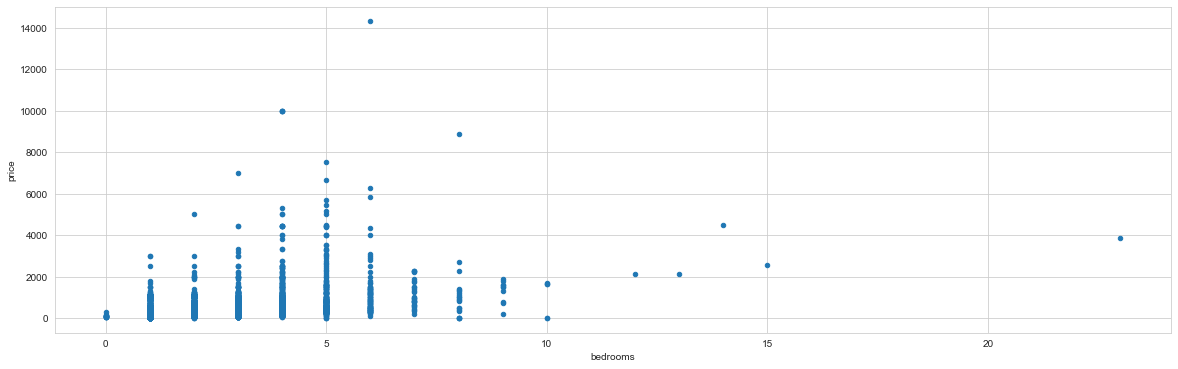

In [65]:
df.plot.scatter(x='bedrooms', y='price', figsize=(20,6))

In [66]:
# Drop the few remaining rows with missing values
df.dropna(inplace=True)

The data set severly lacks in samples for larger houses. I'm going to remove some of the extreme rows for these cases since I'm more interested in examining typically sized houses. Another study could be done for very large rental using data from all over the US.

In [67]:
df['bathrooms'].value_counts().sort_index(ascending=False)

17.0       1
11.0       1
9.0        1
8.0        5
7.5        2
7.0        5
6.5       13
6.0       21
5.5       22
5.0       50
4.5       79
4.0      142
3.5      186
3.0      420
2.5      772
2.0     2245
1.5      759
1.0     6674
0.5       14
0.0        6
Name: bathrooms, dtype: int64

In [68]:
df.groupby('bathrooms').price.median()

bathrooms
0.0       62.0
0.5       70.5
1.0      100.0
1.5      100.0
2.0      249.0
2.5      300.0
3.0      499.0
3.5      600.0
4.0      727.5
4.5      700.0
5.0     1000.0
5.5     1797.5
6.0     1300.0
6.5     2500.0
7.0     1250.0
7.5      920.0
8.0     1500.0
9.0     2100.0
11.0    2550.0
17.0    3875.0
Name: price, dtype: float64

In [69]:
df['accommodates'].value_counts().sort_index(ascending=False)

33       1
32       2
30       1
28       2
25       1
24       4
21       3
20       2
19       2
18       4
17       1
16     255
15      27
14      79
13      30
12     178
11      41
10     426
9      103
8      681
7      250
6     1609
5      633
4     2437
3      951
2     3237
1      458
Name: accommodates, dtype: int64

In [70]:
df.groupby('accommodates').price.mean()

accommodates
1       78.587336
2      115.845845
3      137.920084
4      240.475174
5      236.358610
6      323.032318
7      347.716000
8      529.753304
9      505.844660
10     782.321596
11     729.975610
12     787.101124
13     629.366667
14     918.518987
15     985.740741
16     827.290196
17    1170.000000
18    3776.750000
19    1740.000000
20    2387.500000
21    1722.000000
24    1404.250000
25     633.000000
28    1370.000000
30    2749.000000
32    1882.500000
33    1780.000000
Name: price, dtype: float64

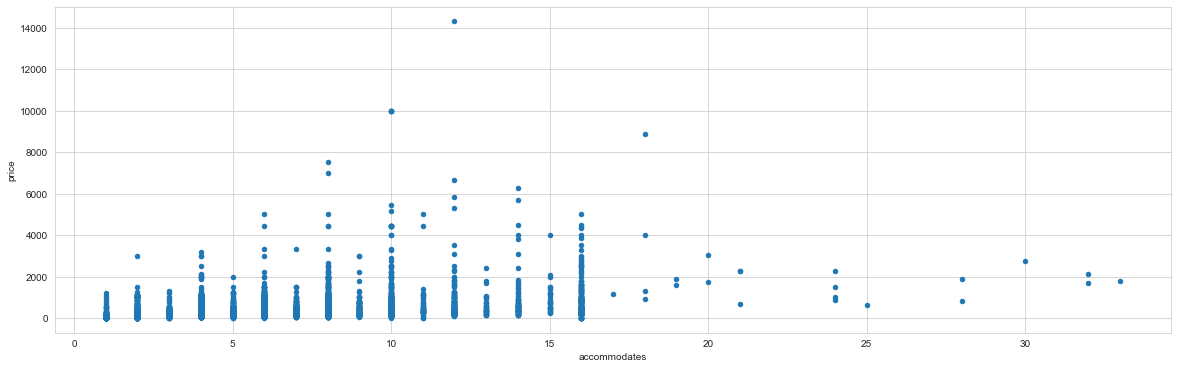

In [71]:
df.plot.scatter(x='accommodates', y='price', figsize=(20,6));

In [72]:
print(df[df['bathrooms'] <= 8])
print(df[df['accommodates'] <= 16])
# Remove extremely large rental listing due to low samples
df = df.loc[df['bathrooms'] <= 8]
df = df.loc[df['accommodates'] <= 16]

                room_type  price  accommodates  bathrooms  bedrooms  \
id                                                                    
2265      Entire home/apt  225.0             4        2.0       2.0   
5245         Private room  100.0             2        1.0       1.0   
5456      Entire home/apt   95.0             3        1.0       1.0   
5769         Private room   40.0             2        1.0       1.0   
6413      Entire home/apt   99.0             2        1.0       1.0   
...                   ...    ...           ...        ...       ...   
42929742  Entire home/apt   60.0             1        1.0       1.0   
42930229  Entire home/apt   40.0             3        1.0       1.0   
42930678  Entire home/apt   40.0             3        1.0       1.0   
42930768  Entire home/apt   45.0             3        1.0       1.0   
42931550     Private room   35.0             6        1.0       1.0   

         host_is_superhost  neighbourhood_cleansed  longitude   latitude  \


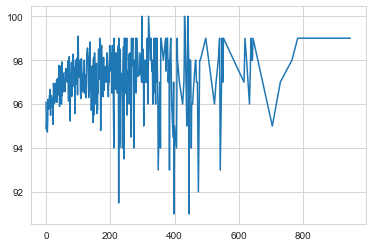

In [73]:
plt.plot(df.groupby('number_of_reviews').review_scores_rating.mean());

### Verify Data Quality
Need to verify that price is a float, review_scores_rating are not missing any values.

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11392 entries, 2265 to 42931550
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   room_type               11392 non-null  object 
 1   price                   11392 non-null  float64
 2   accommodates            11392 non-null  int64  
 3   bathrooms               11392 non-null  float64
 4   bedrooms                11392 non-null  float64
 5   host_is_superhost       11392 non-null  object 
 6   neighbourhood_cleansed  11392 non-null  int64  
 7   longitude               11392 non-null  float64
 8   latitude                11392 non-null  float64
 9   number_of_reviews       11392 non-null  int64  
 10  availability_365        11392 non-null  int64  
 11  review_scores_rating    11392 non-null  float64
 12  minimum_nights          11392 non-null  int64  
 13  listing_url             11392 non-null  object 
 14  price_per_person        11392 no

### Data Preparation 
The data preparation process in the CRISP-DM cycle consists of:

* Select your data
* Clean your data
* Construct required data
* Integrate data (not required for this project)

#### Select your data
* This is the stage of the project where you decide on the data that you're going to use for analysis. [source](https://www.sv-europe.com/crisp-dm-methodology/). To answer the business questions posed at the beginning, I'm choosing to keep the following features:

* 'price' - target feature for the business questions
* 'room_type' - property type: house, private room, shared room
* 'accommodates' - property size metric
* 'bathrooms' - property size metric
* 'bedrooms' - property size metric
* 'host_is_superhost' - Airbnb host status
* 'neighbourhood_cleansed' - Location, ZIP code
* 'number_of_reviews' - Review metric
* 'review_scores_rating' - Review metric
* 'minimum_nights' - length of stay metric

#### Clean your data
This task involves raise the data quality to the level required by the analysis techniques that you've selected [source](https://www.sv-europe.com/crisp-dm-methodology/). I'm creating a 'cleaning' function so that I don't have to repeat the above steps everytime I load the notebook.

In [75]:
def clean_listings_data(csv, review_impute = True):
    '''
    Takes a listings.csv file (insideairbnb.com) for a particular
    city and outputs a cleaned the data frame 
    for the feature_list defined below. Note that the feature_list
    is hardcoded since the cleaning operations may not work for a
    different set of features. 
    
    Input:
    csv - insideairbnb.com listings.csv 
    review_impute - create additional DataFrames with no or '0' imputation 
                    for NaNs in the 'review_scores_rating' column
    
    Output:
    df - Cleaned DataFrame, used for prediction model
    df_no_impute - DataFrame with no imputed values on 'review_scores_rating'
    df_zeros_impute - DataFrame with integer '0' imputed values on 'review_scores_rating'
    '''
    
    # Import and load data
    df = pd.read_csv('data/listings.csv', low_memory=False)
    
    # Select features to keep in DataFrame
    feature_list = ['room_type', 'price', 'accommodates', 'bathrooms', 
                    'bedrooms', 'host_is_superhost', 'neighbourhood_cleansed', 
                    'number_of_reviews', 'review_scores_rating', 'minimum_nights']
    df = df[feature_list]
    
    # Convert price to from currency to float
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].astype(float)
    
    # Create feature for price per person
    df['price_per_person'] = df['price']/df['accommodates']
    
    # Remove rows with > $1000 per person
    df = df.loc[df['price_per_person'] <= 1500.00]
    
    # df for specific plots - need data before 'review_scores_rating' imputation
    df_no_impute = df[['review_scores_rating', 'price', 'price_per_person', 
                    'number_of_reviews', 'bathrooms', 'bedrooms', 'accommodates']].copy()
    df_zeros_impute = df_no_impute.copy()
    df_no_impute.dropna(inplace=True)
    df_zeros_impute['review_scores_rating'].fillna(0, inplace=True)
    df_zeros_impute.dropna(inplace=True)

    # Imputed mean value of review scores to missing data in review_scores_rating feature
    df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)
    
    # Bathrooms is getting scaled later, so I do not care about making it a discrete value
    # Replacing all 0 values in bathrooms with 'NaN'
    df['bathrooms'].replace(0, np.nan, inplace=True)
    df['bathrooms'].fillna((df['accommodates']//2), inplace=True)
    
    df['bedrooms'].replace(0, np.nan, inplace=True)
    df['bedrooms'].fillna((df['accommodates']//2), inplace=True)
    
    # Drop the few remaining rows with missing values
    df.dropna(inplace=True)
    
    # Remove extremely large rental listing due to low samples
    df = df.loc[df['bathrooms'] <= 8]
    df = df.loc[df['accommodates'] <= 16]
    
    print('clean_listings_data: Cleaning Complete')
    
    if review_impute:
        return df, df_no_impute, df_zeros_impute
    else:
        return df

# Run cleanup function
df, df_no_impute, df_zeros_impute = clean_listings_data('data/listings.csv')


clean_listings_data: Cleaning Complete


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11392 entries, 0 to 11667
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   room_type               11392 non-null  object 
 1   price                   11392 non-null  float64
 2   accommodates            11392 non-null  int64  
 3   bathrooms               11392 non-null  float64
 4   bedrooms                11392 non-null  float64
 5   host_is_superhost       11392 non-null  object 
 6   neighbourhood_cleansed  11392 non-null  int64  
 7   number_of_reviews       11392 non-null  int64  
 8   review_scores_rating    11392 non-null  float64
 9   minimum_nights          11392 non-null  int64  
 10  price_per_person        11392 non-null  float64
dtypes: float64(5), int64(4), object(2)
memory usage: 1.0+ MB


In [77]:
df_no_impute.count()

review_scores_rating    8786
price                   8786
price_per_person        8786
number_of_reviews       8786
bathrooms               8786
bedrooms                8786
accommodates            8786
dtype: int64

In [78]:
df_zeros_impute.count()

review_scores_rating    11392
price                   11392
price_per_person        11392
number_of_reviews       11392
bathrooms               11392
bedrooms                11392
accommodates            11392
dtype: int64

### Construct required data
This task includes constructive data preparation operations such as the production of derived attributes or entire new records, or transformed values for existing attributes. source

Now that the DataFrame is cleaned, I want to sort all of the ZIP codes for Austin the into several regions to simplify the analysis. This could be easily updated for anyone who wants to redraw my subjective boundaries. Also, for a different city, the following would need to be redone with the appropriate ZIP codes.

Additionally, I need to create dummy variables and scale the features for the regression models.

In [79]:
# Compress zipcode into 5 regions for 1 hot encoding
zip_central = [78701, 78702, 78703, 78704, 78705, 78712, 78722]
zip_north = [78726, 78727, 78728, 78729, 78731, 78750, 78751,  
             78756, 78758, 78759, 78757]
zip_west = [78730, 78732, 78733, 78734, 78735, 78736, 78738, 78746]
zip_south = [78737, 78739, 78745, 78749, 78748, 78742]
zip_east = [78717, 78719, 78721, 78723, 78724, 78725, 78741, 
            78744, 78747, 78752, 78753, 78754]

map_dict = {}
str_dict = {0: 'Central', 1: 'North', 2: 'West', 3: 'South', 4: 'East'}
area_list = [zip_central, zip_north, zip_west, zip_south, zip_east]

# Create a dict for the pandas map function to convert zip into region
for i in range(len(area_list)):
    for zipcode in area_list[i]:
        map_dict[zipcode] = str_dict[i]   

# Replace 'neighbourhood_cleansed' with 'region' feature
df['region'] = df['neighbourhood_cleansed'].map(map_dict)
df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

In [80]:
df.head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,number_of_reviews,review_scores_rating,minimum_nights,price_per_person,region
0,Entire home/apt,225.0,4,2.0,2.0,t,24,93.0,30,56.250000,Central
1,Private room,100.0,2,1.0,1.0,t,9,91.0,30,50.000000,Central
2,Entire home/apt,95.0,3,1.0,1.0,t,529,97.0,2,31.666667,Central
3,Private room,40.0,2,1.0,1.0,t,257,98.0,1,20.000000,North
4,Entire home/apt,99.0,2,1.0,1.0,t,112,99.0,3,49.500000,Central


In [81]:
print (np.corrcoef(df['bedrooms'], df['accommodates']))

[[1.        0.8261102]
 [0.8261102 1.       ]]


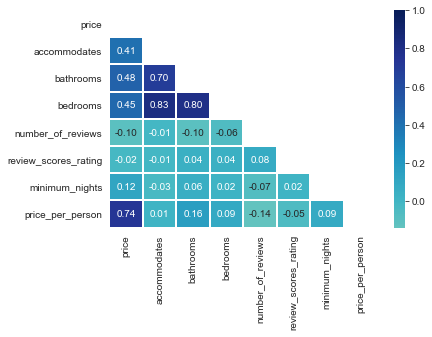

In [82]:
#Create the correlation matrix
corr= df.corr()[:10]
# Draw the heatmap

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, cmap="YlGnBu", center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()


In [83]:
df.to_csv('data/listings_cleaned.csv')

In [84]:
df.isnull().sum()

room_type               0
price                   0
accommodates            0
bathrooms               0
bedrooms                0
host_is_superhost       0
number_of_reviews       0
review_scores_rating    0
minimum_nights          0
price_per_person        0
region                  0
dtype: int64

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11392 entries, 0 to 11667
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   room_type             11392 non-null  object 
 1   price                 11392 non-null  float64
 2   accommodates          11392 non-null  int64  
 3   bathrooms             11392 non-null  float64
 4   bedrooms              11392 non-null  float64
 5   host_is_superhost     11392 non-null  object 
 6   number_of_reviews     11392 non-null  int64  
 7   review_scores_rating  11392 non-null  float64
 8   minimum_nights        11392 non-null  int64  
 9   price_per_person      11392 non-null  float64
 10  region                11392 non-null  object 
dtypes: float64(5), int64(3), object(3)
memory usage: 1.0+ MB
